In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create image generator
train_generator = ImageDataGenerator(
    rescale=1/255, horizontal_flip=True, rotation_range=5, validation_split=0.2)
test_generator = ImageDataGenerator(rescale=1/255)

In [35]:
import os

# Train, validation and test sets
trainset = train_generator.flow_from_directory(
    os.path.join('cifar10', 'train'), batch_size=32, target_size=(32, 32),
    shuffle=True, subset='training')
validset = train_generator.flow_from_directory(
    os.path.join('cifar10', 'train'), batch_size=32, target_size=(32, 32),
    shuffle=False, subset='validation')
testset = test_generator.flow_from_directory(
    os.path.join('cifar10', 'test'), batch_size=32, target_size=(32, 32),
    shuffle=False)


Found 4000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 1002 images belonging to 10 classes.


In [36]:
import tensorflow.keras as keras
from tensorflow.keras import activations

# Convolutional Network
model = keras.Sequential()


model.add(keras.layers.Conv2D(filters=64, kernel_size=5, strides=2,
                              activation='relu', input_shape=(32, 32, 3)))
model.add(keras.layers.MaxPool2D(pool_size=3))
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, strides=1,
                              activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))
model.add(keras.layers.Flatten())


# Hidden layer
model.add(keras.layers.Dense(units=512, activation='relu'))
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(units=32, activation='relu'))




model.add(keras.layers.Dense(units=trainset.num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 14, 14, 64)        4864      
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 4, 4, 64)          0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 2, 2, 64)          36928     
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 1, 1, 64)          0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 64)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 512)               33280     
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
__________

In [37]:
# Compile the model
model.compile(optimizer=keras.optimizers.Adamax(), loss='categorical_crossentropy', metrics=['acc'])

In [38]:
# End training when accuracy stops improving (optional)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=6)

In [39]:
# Train model
history = model.fit_generator(
    generator=trainset, validation_data=validset, epochs=100, callbacks=[early_stopping])

Epoch 1/100
125/125 [==============================] - 4s 30ms/step - loss: 2.2424 - acc: 0.1370 - val_loss: 2.0987 - val_acc: 0.1950
Epoch 2/100
125/125 [==============================] - 3s 21ms/step - loss: 2.0939 - acc: 0.2010 - val_loss: 1.9869 - val_acc: 0.2120
Epoch 3/100
125/125 [==============================] - 3s 21ms/step - loss: 1.9762 - acc: 0.2345 - val_loss: 1.8816 - val_acc: 0.2900
Epoch 4/100
125/125 [==============================] - 3s 21ms/step - loss: 1.8871 - acc: 0.2747 - val_loss: 1.8778 - val_acc: 0.2860
Epoch 5/100
125/125 [==============================] - 3s 21ms/step - loss: 1.8573 - acc: 0.2920 - val_loss: 1.7700 - val_acc: 0.3480
Epoch 6/100
125/125 [==============================] - 3s 22ms/step - loss: 1.7740 - acc: 0.3362 - val_loss: 1.7707 - val_acc: 0.3500
Epoch 7/100
125/125 [==============================] - 3s 21ms/step - loss: 1.7291 - acc: 0.3473 - val_loss: 1.6901 - val_acc: 0.3660
Epoch 8/100
125/125 [==============================] - 3s 21ms

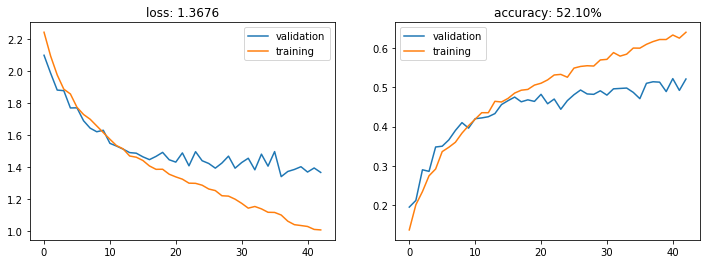

In [40]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot loss values
ax1.set_title('loss: {:.4f}'.format(history.history['val_loss'][-1]))
ax1.plot(history.history['val_loss'], label='validation')
ax1.plot(history.history['loss'], label='training')
ax1.legend()

# plot accuracy values
ax2.set_title('accuracy: {:.2f}%'.format(history.history['val_acc'][-1]*100))
ax2.plot(history.history['val_acc'], label='validation')
ax2.plot(history.history['acc'], label='training')
ax2.legend()

plt.show()

In [41]:
test_preds = model.predict_generator(testset)
print('Predictions:', test_preds.shape) # (1000, 10)

Predictions: (1002, 10)


In [42]:
from sklearn.metrics import confusion_matrix
import pandas as pd

# Compute confusion matrix
matrix = confusion_matrix(
    y_true=testset.classes, # array with true labels
    y_pred=test_preds.argmax(axis=1) # array with predicted labels
)

# Format as a DataFrame
class_names = list(testset.class_indices.keys())
matrix_df = pd.DataFrame(data=matrix, columns=class_names, index=class_names)
matrix_df.columns.name = 'Predictions'
matrix_df.index.name = 'True class'
matrix_df

Predictions,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
True class,,,,,,,,,,
airplane,57,9,4,1,5,3,3,2,11,7
automobile,3,69,3,0,1,2,1,3,2,16
bird,10,3,38,10,5,10,10,8,4,2
cat,2,4,10,22,7,25,13,12,1,4
deer,2,4,11,10,32,8,8,20,3,2
dog,0,0,13,19,3,41,7,14,1,2
frog,0,5,6,4,3,3,74,3,1,1
horse,0,3,2,6,3,5,2,74,0,5
ship,25,12,1,5,2,2,0,1,42,10
